# Helsingborg City Insights

### Parking Insights

Import all packages

In [1]:
import numpy as np
import pandas as pd
import json

import matplotlib as mlt
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [2]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Load Data

#  Extract Missing Area name for a pincode 

## 1.1) Based on Area name(B-Område) Geo Polygon shape in a map

Every postal code has a geo location coordinate, check if this point belongs to B-område(represented with a polygon coordinates), if postal code geo location belongs to this B-område polygon, assign B-Område value to this postal code, repeat this for all the postal codes.

Based on the data there are 42 + 2 different areas in Helsingborg.

The below data has Area name(B-Område) but no pincode, we use this data to extract name for a pincode in Helsingborg

In [4]:
#Coordinates in tuple format helps to create a polygon using shapely.geometry.polygon
def transform_coordinates_to_tuples(row):
    tuple_list=None
    np_array = np.array(row['coordinates'])
    has_multipolygons = len(np_array.shape) > 2  
    if has_multipolygons :
        tuple_list = []
        for coordinate in np_array[0]:
            tuple_list.append((coordinate[0],coordinate[1] )) 
    else:
        tuple_list = []
        for each_polygon in np_array:
            coordinates = []
            for coordinate in each_polygon[0]:
                coordinates.append((coordinate[0],coordinate[1] ))
            tuple_list.append(coordinates)
                      
    return tuple_list

In [5]:
stats_df = pd.read_csv("./data/statistikomraden-helsingborg.csv", sep=';')
s_columns = ['B-område', 'B-områdeskod','geo_shape', 'geo_point_2d']
stats_df = stats_df[s_columns]

stats_df = stats_df.join( pd.DataFrame(json.loads(geoshape).values() for geoshape in stats_df['geo_shape']) )
stats_df.rename(columns={0:'type',1:'coordinates'}, inplace=True)
stats_df['polygon_coordinates'] = stats_df.apply(transform_coordinates_to_tuples, axis=1)

print(stats_df.shape)
stats_df.head(2)

#formatted = formatted[formatted['type']=='Polygon'] # removed one entry for MultiPolygon

(1399, 7)


,B-område,B-områdeskod,geo_shape,geo_point_2d,type,coordinates,polygon_coordinates
0,Norr,1,"{""type"": ""Polygon"", ""coordinates"": [[[12.68153...","56.0676866129,12.6823508361",Polygon,"[[[12.681537204451763, 56.0686493870443], [12....","[(12.681537204451763, 56.0686493870443), (12.6..."
1,Norr,1,"{""type"": ""Polygon"", ""coordinates"": [[[12.66121...","56.0790261499,12.6634044122",Polygon,"[[[12.661211760212481, 56.08056657675145], [12...","[(12.661211760212481, 56.08056657675145), (12...."


In [6]:
"""stats_df = stats_df.join( pd.DataFrame(json.loads(geoshape).values() for geoshape in stats_df['geo_shape']) )
stats_df.rename(columns={0:'type',1:'coordinates'}, inplace=True)
stats_df['polygon_coordinates'] = stats_df.apply(transform_coordinates_to_tuples, axis=1)
print(stats_df.shape)
stats_df.head(2)"""

"stats_df = stats_df.join( pd.DataFrame(json.loads(geoshape).values() for geoshape in stats_df['geo_shape']) )\nstats_df.rename(columns={0:'type',1:'coordinates'}, inplace=True)\nstats_df['polygon_coordinates'] = stats_df.apply(transform_coordinates_to_tuples, axis=1)\nprint(stats_df.shape)\nstats_df.head(2)"

## 1.2) Below dataframe has Pincode but no area name.

In [7]:
postal_df = pd.read_csv("./data/postnummer_new.csv", sep=';')
p_columns = ['CITY', 'POSTCODE', 'geo_shape', 'geo_point_2d']
postal_df = postal_df[p_columns]
#bb= postal_df["POSTCODE"].value_counts().rename_axis("postnumber").reset_index(name='counts').drop(['counts'], axis=1).sort_values(["postnumber"]).reset_index(drop="index")#.to_csv("./data/sorted_postnumber2.csv", index=False)
#postal_df.rename(columns={'geo_shape': 'GEOSHAPE', 'geo_point_2d':'GEOPOINT2D'}, inplace=True)
postal_df.head(2)

,CITY,POSTCODE,geo_shape,geo_point_2d
0,Helsingborg,25482,"{""type"": ""Polygon"", ""coordinates"": [[[12.65947...","56.0894565738,12.6568019271"
1,Helsingborg,25361,"{""type"": ""Polygon"", ""coordinates"": [[[12.74727...","56.0132736825,12.7530666401"


# Code for extracting area name for a pincode in Helsingborg

In [8]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [9]:
def check_coordinate(row, coord):
    isInGivenPolygon = False
    point = Point(coord[1], coord[0])
    if row['type'] == 'MultiPolygon':
        checks=[]
        for polygon_points in row['polygon_coordinates']:
            polygon = Polygon(polygon_points)
            checks.append(polygon.contains(point))
        isInGivenPolygon = any(checks)
    else:
        polygon = Polygon(row['polygon_coordinates'])
        isInGivenPolygon = polygon.contains(point)
    return isInGivenPolygon

def fetch_area_name(geo_2d_row, data_frame, column_name):
    name = ""
    coord = tuple(map(float, geo_2d_row.split(','))) 
    check = data_frame.apply(check_coordinate, coord=coord, axis=1)

    if any(check):
        name = data_frame[check].reset_index(drop='index').loc[0,column_name] 
    else:
        print(geo_2d_row)
    return name

postal_df['area'] = postal_df['geo_point_2d'].apply(fetch_area_name, data_frame=stats_df, column_name='B-område')
#formatted['area'] = postal_df['area']
#Bjuv Municipality - 55.9830205042, 12.9606739633
#Höganäs Municipality - 56.1368870444, 12.5918569047
#postal_df.loc[85, 'area'] 
#postal_df.loc[121, 'area']
postal_df.head(2)

55.9830205042,12.9606739633
56.1368870444,12.5918569047


,CITY,POSTCODE,geo_shape,geo_point_2d,area
0,Helsingborg,25482,"{""type"": ""Polygon"", ""coordinates"": [[[12.65947...","56.0894565738,12.6568019271",Hittarp - Laröd
1,Helsingborg,25361,"{""type"": ""Polygon"", ""coordinates"": [[[12.74727...","56.0132736825,12.7530666401",Ättekulla


In [10]:
# Updating missing values
postal_df.loc[85, 'area'] = 'Bjuv'
postal_df.loc[121, 'area'] = 'Höganäs'

In [11]:
postal_df[postal_df['area']=='']

,CITY,POSTCODE,geo_shape,geo_point_2d,area


In [12]:
postal_df = postal_df.join( pd.DataFrame(json.loads(geoshape).values() for geoshape in postal_df['geo_shape']))
postal_df.rename(columns={0:'type',1:'coordinates'}, inplace=True)
#postal_df.drop([0],inplace=True, axis=1) 
postal_df['polygon_coordinates'] = postal_df.apply(transform_coordinates_to_tuples, axis=1)
print(postal_df.shape)
print(len(postal_df['area'].value_counts()))
postal_df.head(2)

(127, 8)
44


,CITY,POSTCODE,geo_shape,geo_point_2d,area,type,coordinates,polygon_coordinates
0,Helsingborg,25482,"{""type"": ""Polygon"", ""coordinates"": [[[12.65947...","56.0894565738,12.6568019271",Hittarp - Laröd,Polygon,"[[[12.65947745564023, 56.08065244077402], [12....","[(12.65947745564023, 56.08065244077402), (12.6..."
1,Helsingborg,25361,"{""type"": ""Polygon"", ""coordinates"": [[[12.74727...","56.0132736825,12.7530666401",Ättekulla,Polygon,"[[[12.747272091715816, 56.01611001498235], [12...","[(12.747272091715816, 56.01611001498235), (12...."


# Now postalcodes have a area name

In [13]:
#postal_df.to_csv('./data/processed/postal_numbers_with_areaname.csv', index=False, sep=';')

In [14]:
smiley_df = pd.read_csv("./data/smileygodkanda-platser-i-helsingborg.csv", sep=';')

In [15]:
#postal_df['area'] = postal_df['geo_point_2d'].apply(fetch_area_name, data_frame=stats_df, column_name='B-område')
smiley_df['area'] = smiley_df['geo_point_2d'].apply(fetch_area_name, data_frame=stats_df, column_name='B-område')
smiley_df.head(2)

,KATEGORI,NAMN,ADRESS,HEMSIDA,Kategori webb,Exportdatum,geo_shape,geo_point_2d,area
0,Butiker,Borgmans Fisk Eftr,Kopparmöllegatan 17,http://www.borgmansfisk.net/,Butiker,2020-07-16,"{""type"": ""Point"", ""coordinates"": [12.697555275...","56.0534616304,12.6975552755",Slottshöjden
1,Butiker,Polshop,Södergatan 16,http://www.polshop.se/,Butiker,2020-07-16,"{""type"": ""Point"", ""coordinates"": [12.701065141...","56.0421044698,12.7010651416",Söder


In [16]:
def check_coordinate(row, coord):
    isInGivenPolygon = False
    point = Point(coord[1], coord[0])
    if row['type'] == 'MultiPolygon':
        checks=[]
        for polygon_points in row['polygon_coordinates']:
            polygon = Polygon(polygon_points)
            checks.append(polygon.contains(point))
        isInGivenPolygon = any(checks)
    else:
        polygon = Polygon(row['polygon_coordinates'])
        isInGivenPolygon = polygon.contains(point)
    return isInGivenPolygon

def fetch_pincode(geo_2d_row, data_frame, column_name):
    postcode = ""
    coord = tuple(map(float, geo_2d_row.split(','))) 
    check = data_frame.apply(check_coordinate, coord=coord, axis=1)

    if any(check):
        postcode = data_frame[check].reset_index(drop='index').loc[0,column_name] 
    else:
        print(geo_2d_row)
    return postcode

smiley_df['postalcode'] = smiley_df['geo_point_2d'].apply(fetch_pincode, data_frame=postal_df, column_name='POSTCODE')
#Missing value update
#smiley_df.loc[140, 'postalcode'] = '25267'

smiley_df = smiley_df[~(smiley_df['postalcode']=='')]
print(smiley_df[smiley_df['postalcode']==''])
smiley_df.head(2)

56.0494005107,12.6864986671
Empty DataFrame
Columns: [KATEGORI, NAMN, ADRESS, HEMSIDA, Kategori webb, Exportdatum, geo_shape, geo_point_2d, area, postalcode]
Index: []


,KATEGORI,NAMN,ADRESS,HEMSIDA,Kategori webb,Exportdatum,geo_shape,geo_point_2d,area,postalcode
0,Butiker,Borgmans Fisk Eftr,Kopparmöllegatan 17,http://www.borgmansfisk.net/,Butiker,2020-07-16,"{""type"": ""Point"", ""coordinates"": [12.697555275...","56.0534616304,12.6975552755",Slottshöjden,25435
1,Butiker,Polshop,Södergatan 16,http://www.polshop.se/,Butiker,2020-07-16,"{""type"": ""Point"", ""coordinates"": [12.701065141...","56.0421044698,12.7010651416",Söder,25225


In [17]:
smiley_df[['Latitude','Longitude']] = smiley_df.geo_point_2d.str.split(',', expand=True).astype(float)


In [18]:
#smiley_df.to_csv('./data/processed/smiley_with_area_and_pincode.csv', index=False,sep=';')

# Helsingborg Business activities on Map
## Smiley :) approved places

In [19]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Helsingborg'

geolocator = Nominatim(user_agent="helsingborg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Helsingborg are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Helsingborg are 56.0441984, 12.7040684.


In [20]:
#df.replace(dictionary, regex=True, inplace=True)
temp_smiley_df=pd.DataFrame()
temp_smiley_df[['P','A','K','N']] = smiley_df[['postalcode','area','KATEGORI','NAMN']]
dictionary ={'ä':'a:','Ä':'A:', 'ö':'o:','Ö':'O:', 'å':'a;','Å':'A;', 'é':'e'}
temp_smiley_df.replace(dictionary, regex=True, inplace=True)


In [21]:
import folium
helsingborg_map = folium.Map(location=[latitude, longitude], zoom_start=12)
helsingborg_map

In [22]:
# add markers to map
for lat, lng, postal_code, area_name, category, business_name in zip(smiley_df['Latitude'], smiley_df['Longitude'], temp_smiley_df['P'], temp_smiley_df['A'], temp_smiley_df['K'], temp_smiley_df['N']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=(
            "<b>{business_name}</b><br>"
            "<i>{category}</i><br>"
            "<b><i>{area_name}, {postal_code}.</i></b>"
        ).format(business_name=business_name, category=str(category), area_name=str(area_name), postal_code=str(postal_code) ),
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(helsingborg_map)  
    
helsingborg_map

# One hot encoding

In [23]:
hbg_venues_onehot = pd.get_dummies(smiley_df[['KATEGORI']], prefix="", prefix_sep="") # size -> (281, 7)
print(hbg_venues_onehot.shape)
hbg_venues_onehot.head()

(280, 7)


,Butiker,Caféer,Personalrestauranger,Restauranger,Skolrestauranger,Snabbmat,Vårdverksamheter
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [24]:

hbg_venues_onehot['postalcode'] = smiley_df['postalcode'] # size -> (2163, 275)

fixed_columns = [hbg_venues_onehot.columns[-1]] + list(hbg_venues_onehot.columns[:-1])
hbg_venues_onehot = hbg_venues_onehot[fixed_columns]

hbg_venues_onehot.head()

,postalcode,Butiker,Caféer,Personalrestauranger,Restauranger,Skolrestauranger,Snabbmat,Vårdverksamheter
0,25435,1,0,0,0,0,0,0
1,25225,1,0,0,0,0,0,0
2,25223,1,0,0,0,0,0,0
3,25267,1,0,0,0,0,0,0
4,25250,1,0,0,0,0,0,0


In [25]:
#Group area and calculate mean of occurance of each category, each occurance is represented as 1 in onehot encoding
hbg_grouped_mean = hbg_venues_onehot.groupby('postalcode').mean().reset_index()
print(len(hbg_grouped_mean)) # by area size is -> 40, by postalcode size is 97
hbg_grouped_mean.head(2)


96


,postalcode,Butiker,Caféer,Personalrestauranger,Restauranger,Skolrestauranger,Snabbmat,Vårdverksamheter
0,25220,0.0,0.00,0.0,1.000000,0.000000,0.000000,0.0
1,25221,0.0,0.25,0.0,0.583333,0.083333,0.083333,0.0


In [26]:
def get_most_common_business(row, top_business):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)   
    return row_categories_sorted.index.values[0:top_business]

top_business = 5
numerical_indicators = ['st', 'nd', 'rd']

# create columns according to number of top business
columns = ['postalcode']
for business_place in np.arange(top_business):
    try:
        columns.append('{}{}'.format(business_place+1, numerical_indicators[business_place])) # Outof Index error expected
    except:
        columns.append('{}th'.format(business_place+1))

# create a new dataframe
business_sorted_by_occurance = pd.DataFrame(columns=columns)
business_sorted_by_occurance['postalcode'] = hbg_grouped_mean['postalcode']

for index in np.arange(hbg_grouped_mean.shape[0]):
    business_sorted_by_occurance.iloc[index, 1:] = get_most_common_business(hbg_grouped_mean.iloc[index, :], top_business)

print(business_sorted_by_occurance.shape) 
business_sorted_by_occurance.head()


(96, 6)


,postalcode,1st,2nd,3rd,4th,5th
0,25220,Restauranger,Vårdverksamheter,Snabbmat,Skolrestauranger,Personalrestauranger
1,25221,Restauranger,Caféer,Snabbmat,Skolrestauranger,Vårdverksamheter
2,25222,Caféer,Vårdverksamheter,Snabbmat,Skolrestauranger,Restauranger
3,25223,Skolrestauranger,Restauranger,Snabbmat,Personalrestauranger,Caféer
4,25224,Restauranger,Vårdverksamheter,Snabbmat,Skolrestauranger,Personalrestauranger


# *k*-means cluster

In [27]:
#Below selected data is used for k-means clustering
hbg_grouped_mean_clustering = hbg_grouped_mean.drop('postalcode', 1)
hbg_grouped_mean_clustering.head()

,Butiker,Caféer,Personalrestauranger,Restauranger,Skolrestauranger,Snabbmat,Vårdverksamheter
0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,0.000000,0.250000,0.000000,0.583333,0.083333,0.083333,0.000000
2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.090909,0.090909,0.090909,0.272727,0.272727,0.181818,0.000000
4,0.000000,0.000000,0.000000,0.777778,0.000000,0.111111,0.111111


## Find optimal *k* value by The Elbow Method

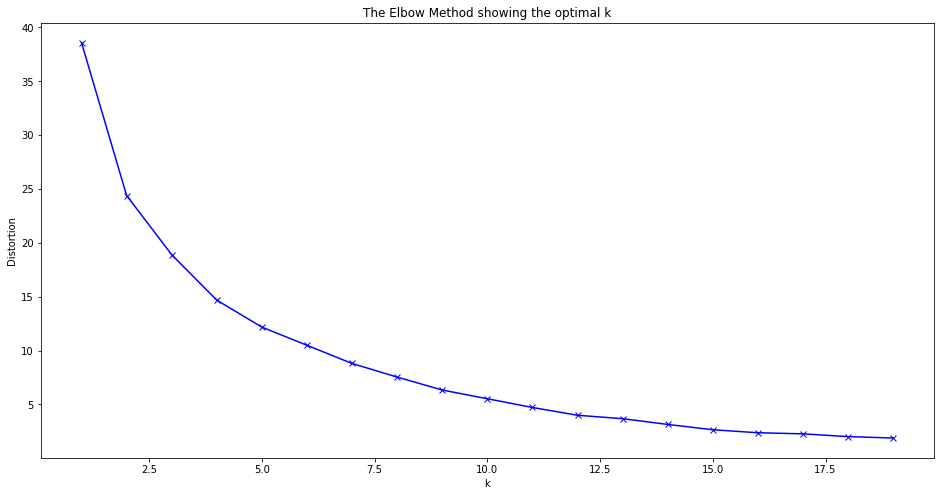

In [28]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeanModel.fit(hbg_grouped_mean_clustering)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [29]:
# set number of clusters
k_clusters = 7

# run k-means clustering
k_means = KMeans(n_clusters=k_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(hbg_grouped_mean_clustering)

# check cluster labels generated for each row in the dataframe
k_means.labels_ #Size -> 40 -> 40 diff areas

array([2, 4, 0, 4, 2, 4, 5, 3, 4, 3, 2, 3, 4, 6, 3, 3, 3, 6, 2, 5, 3, 4,
       0, 6, 6, 4, 4, 2, 0, 0, 0, 3, 6, 3, 1, 6, 6, 3, 0, 4, 1, 6, 3, 6,
       3, 4, 4, 3, 6, 3, 4, 6, 3, 3, 3, 6, 1, 3, 6, 3, 0, 3, 1, 4, 1, 0,
       3, 3, 0, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 2, 1, 3, 6, 3, 3, 0, 4,
       3, 1, 6, 3, 4, 4, 2, 0])

In [30]:
#business_sorted_by_occurance.insert(0, 'cluster_labels', k_means.labels_) #SIZE -> (40,9)
business_sorted_by_occurance['cluster_labels'] = pd.DataFrame(k_means.labels_)
business_sorted_by_occurance.shape

(96, 7)

In [31]:
merged_smiley_df = smiley_df.join(business_sorted_by_occurance.set_index('postalcode'), on='postalcode') #size (281,19)

#dictionary ={'ä':'a:','Ä':'A:', 'ö':'o:','Ö':'O:', 'å':'a;','Å':'A;', 'é':'e'}
merged_smiley_df.replace(dictionary, regex=True, inplace=True)
merged_smiley_df.head(1)

,KATEGORI,NAMN,ADRESS,HEMSIDA,Kategori webb,Exportdatum,geo_shape,geo_point_2d,area,postalcode,Latitude,Longitude,1st,2nd,3rd,4th,5th,cluster_labels
0,Butiker,Borgmans Fisk Eftr,Kopparmo:llegatan 17,http://www.borgmansfisk.net/,Butiker,2020-07-16,"{""type"": ""Point"", ""coordinates"": [12.697555275...","56.0534616304,12.6975552755",Slottsho:jden,25435,56.053462,12.697555,Butiker,Va;rdverksamheter,Snabbmat,Skolrestauranger,Restauranger,4


In [32]:
postal_geo_df = postal_df[["POSTCODE","geo_shape"]].rename(columns={'POSTCODE':"postalcode", "geo_shape":"geo_poly_shape"}).set_index('postalcode')
merged_smiley_df = merged_smiley_df.join(postal_geo_df, on='postalcode') 
merged_smiley_df.head(1)

#merged_smiley_df[merged_smiley_df['geo_poly_shape'].isnull()]

,KATEGORI,NAMN,ADRESS,HEMSIDA,Kategori webb,Exportdatum,geo_shape,geo_point_2d,area,postalcode,Latitude,Longitude,1st,2nd,3rd,4th,5th,cluster_labels,geo_poly_shape
0,Butiker,Borgmans Fisk Eftr,Kopparmo:llegatan 17,http://www.borgmansfisk.net/,Butiker,2020-07-16,"{""type"": ""Point"", ""coordinates"": [12.697555275...","56.0534616304,12.6975552755",Slottsho:jden,25435,56.053462,12.697555,Butiker,Va;rdverksamheter,Snabbmat,Skolrestauranger,Restauranger,4,"{""type"": ""Polygon"", ""coordinates"": [[[12.69620..."


In [ ]:
merged_smiley_df.to_csv('./data/processed/smiley_processed_data_for_visuals.csv', index=False,sep=';')

# Visualize Cluster

In [33]:
def parse_and_update_geometry(geometry, pincode):   
    geometry = json.loads(geometry)
    geometry['name'] = pincode     
    return geometry

def get_geojson(geo_df):
    #assert type(data) == list, "The parameter data should be a list of coordinates with a name argument!"
    
    geo_json = {
        "type": "FeatureCollection",
        "features": [
        {
            "type": "Feature",
            "geometry" : parse_and_update_geometry(geometry, postal_code),
            "properties" : {'name': postal_code},
            
         } for geometry, postal_code in zip(geo_df['geo_poly_shape'], geo_df['postalcode'])]
    }
    
    return geo_json

geo_json=get_geojson(merged_smiley_df)


In [34]:
# create map
hsb_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='Stamen Toner')
# Choropleth layer
hsb_clusters_map.choropleth(
    geo_data=geo_json,
    name='Helsingborg',
    data=merged_smiley_df,
    columns=['postalcode', 'cluster_labels'],
    fill_color='YlGn',
        fill_opacity=0.7, 
    line_opacity=0.2,
    key_on='feature.geometry.name',
    legend_name='Helsingborg_City'
)
# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, postalcode, area, cluster, category in zip(merged_smiley_df['Latitude'], merged_smiley_df['Longitude'], merged_smiley_df['postalcode'], merged_smiley_df['area'], merged_smiley_df['cluster_labels'], merged_smiley_df['KATEGORI']):   
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=(
            "<b>{postalcode}, {area}</b><br>"
            "<i>Cluster {cluster}</i><br>"
            "<b><i>{category}.</i></b>"
        ).format(postalcode=postalcode, area=area, cluster=str(cluster), category=str(category)),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(hsb_clusters_map)
       
hsb_clusters_map